In [1]:
import pandas as pd
from pathlib import Path
import pymc3 as pm
import matplotlib.pyplot as plt

# Read in the data
df = pd.read_csv(Path('week06') / "reedfrogs.csv", sep = ";")

Exercise 1

In [3]:
df["tank"] = df.index

tank_ids = df["tank"].values
n_tadpoles = df["density"].values
n_survived = df["surv"].values

plots = {}
for lam in [0.1, 1, 10]:

    with pm.Model() as model:
        # Define hyperpriors
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        sigma = pm.Exponential("sigma", lam=lam)

        alpha_j = pm.Normal("alpha_j", mu=alpha, sigma=sigma, shape=len(df["tank"].unique()))
        p_j = pm.Deterministic("p_j", pm.math.invlogit(alpha_j[tank_ids]))
        # alpha_j = pm.Normal("alpha_j", mu=alpha, sigma=sigma, shape=1)
        # p_j = pm.Deterministic("p_j", pm.math.invlogit(alpha_j[0]))

        # Define observed data
        y = pm.Binomial("y", n=n_tadpoles, p=p_j, observed=n_survived)

    # prior predictive check
    with model:
        prior_checks = pm.sample_prior_predictive(samples=1000)

    # build df for plotting
    prior_checks_df = pd.DataFrame(prior_checks["p_j"])
    prior_checks_df["id"] = prior_checks_df.index.astype(str)
    prior_checks_df = pd.melt(prior_checks_df, id_vars="id", var_name="tank", value_name="p_j")



    from plotnine import ggplot, aes, geom_density

    p = ggplot(prior_checks_df, aes(x="p_j")) + geom_density(alpha=0.1)
    plots[lam] = p



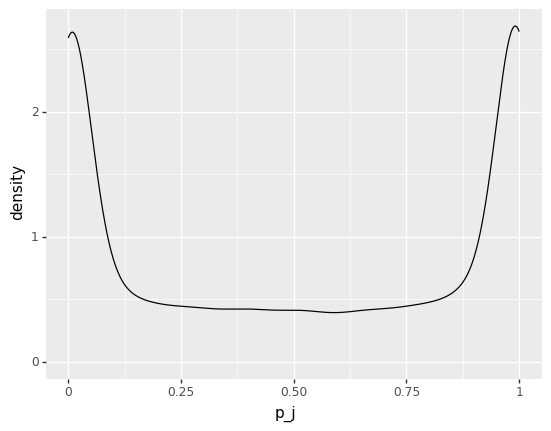

<ggplot: (334393320)>

In [4]:
plots[0.1] 

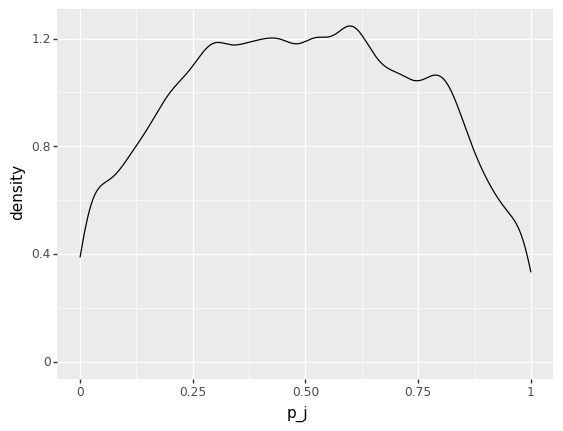

<ggplot: (337245263)>

In [5]:
plots[1]

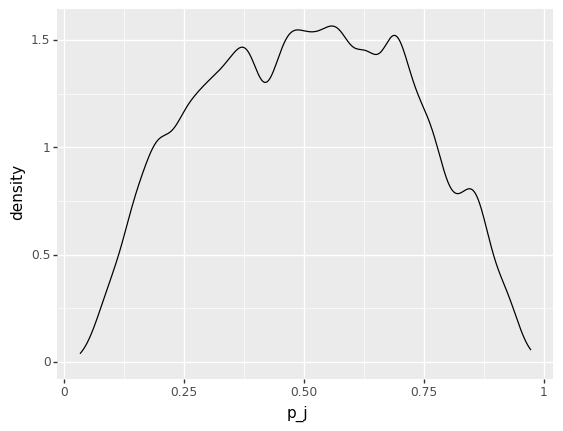

<ggplot: (337425839)>

In [6]:
plots[10]


Exercise 2

In [7]:
with pm.Model() as model:
    # Define hyperpriors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    alpha_j = pm.Normal("alpha_j", mu=alpha, sigma=sigma, shape=len(df["tank"].unique()))
    p_j = pm.Deterministic("p_j", pm.math.invlogit(alpha_j[tank_ids]))

    # Define observed data
    y = pm.Binomial("y", n=n_tadpoles, p=p_j, observed=n_survived)


In [8]:
with model:
    trace = pm.sample(1000, tune=1000, cores=4)

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_j, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


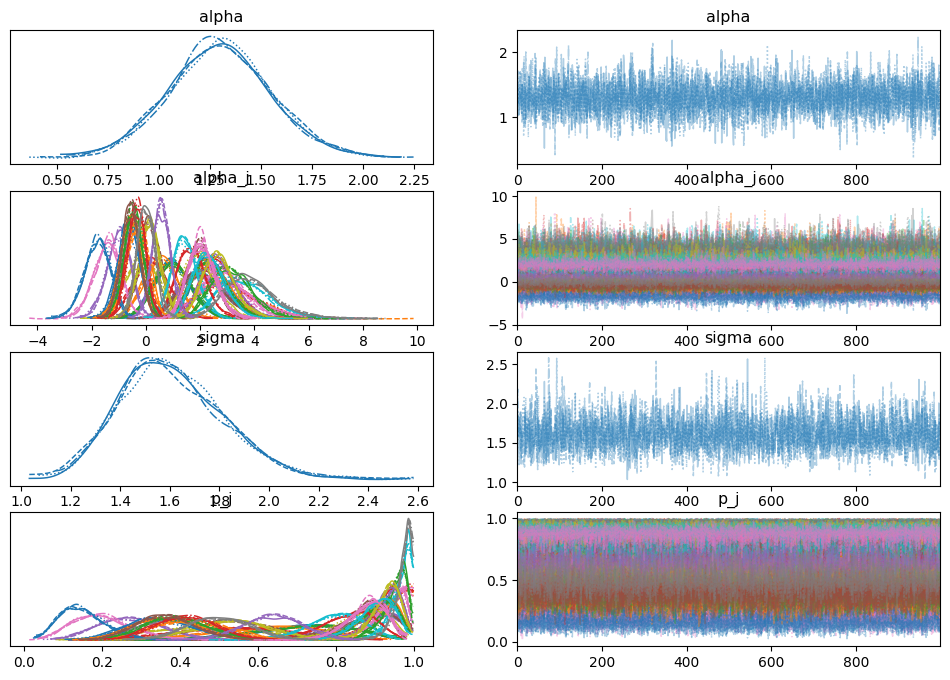

In [19]:
with model:
    pm.plot_trace(trace)
    plt.show()


* Size -> Surv
* Pred -> Surv

And in theory, not size -> pred and not pred -> size.

* Pred -> Escape space
* Size -> Escape space
* Escape space -> Surv

In [31]:
df["pred_size"] = df["pred"] + "__" + df["size"]
pred_size = df["pred_size"].astype("category").cat.codes.values


with pm.Model() as model:
    # Define hyperpriors
    sigma = pm.Exponential("sigma", lam=1)
    alpha_predsize = pm.Normal("alpha_predsize", mu=0, sigma=1, shape=len(df["pred_size"].unique()))
    alpha_j = pm.Normal("alpha_j", mu=alpha_predsize[pred_size], sigma=sigma, shape=len(df["tank"].unique()))
    p_j = pm.Deterministic("p_j", pm.math.invlogit(alpha_j[tank_ids]))

    # Define observed data
    y = pm.Binomial("y", n=n_tadpoles, p=p_j, observed=n_survived)


In [32]:
with model:
    trace = pm.sample(1000, tune=1000, cores=4)

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_j, alpha_predsize, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
df["pred_size_idx"] = pred_size
df.loc[:, ["pred_size", "pred_size_idx"]].drop_duplicates()

,pred_size,pred_size_idx
0,no__big,0
4,no__small,1
8,pred__big,2
12,pred__small,3


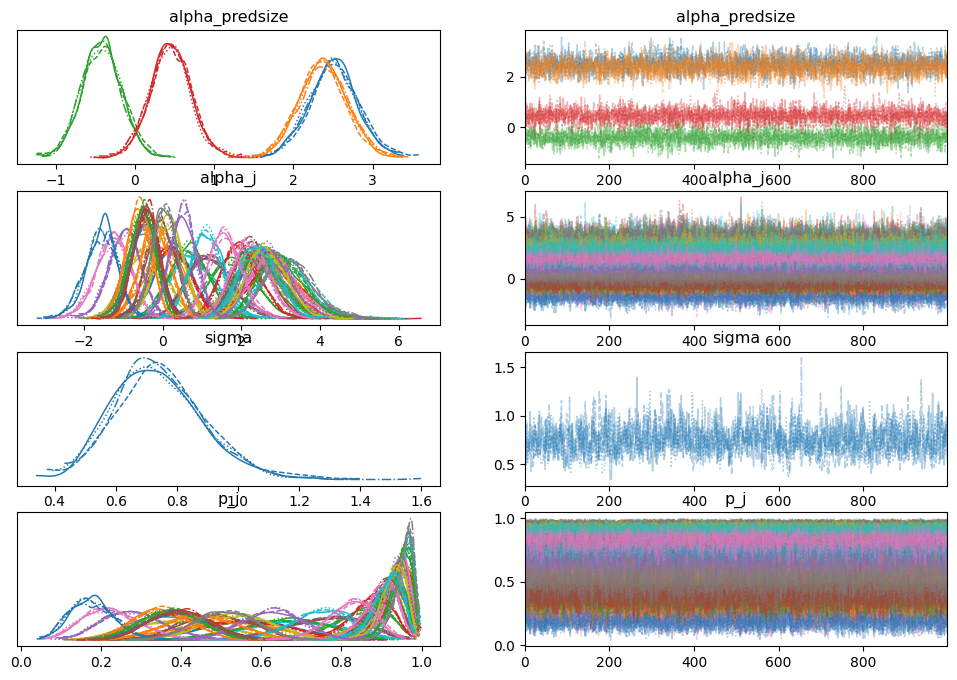

In [38]:
with model:
    # pm.plot_trace(trace, var_names=["alpha_predsize"], compact=False)
    pm.plot_trace(trace)
    plt.show()


In [39]:
with model:
    posteriors = pm.sample_posterior_predictive(
        trace, var_names=["alpha_predsize"], random_seed=43, samples=1000
    )

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


In [65]:
posteriors["alpha_predsize"].mean(axis=0)

array([ 2.49562546,  2.37921378, -0.4205584 ,  0.45219446])

In [50]:
print("impact for big, logit space", (posteriors["alpha_predsize"][:, 2] - posteriors["alpha_predsize"][:, 0]).mean())
print("impact for small, logit space", (posteriors["alpha_predsize"][:, 3] - posteriors["alpha_predsize"][:, 1]).mean())

impact for big, logit space -2.916183856042021
impact for small, logit space -1.9270193269989653


In [56]:

import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print("impact for big", sigmoid(posteriors["alpha_predsize"][:, 2]).mean() - sigmoid(posteriors["alpha_predsize"][:, 0]).mean())
print("impact for small", sigmoid(posteriors["alpha_predsize"][:, 3]).mean() - sigmoid(posteriors["alpha_predsize"][:, 1]).mean())

impact for big -0.5232309522233074
impact for small -0.3030091030537927


Exerecise 3

* Density -> Surv
* Pred -> Surv

And in theory, not Density -> pred and not pred -> Density.

* Pred -> Escape space
* Density -> Escape space
* Escape space -> Surv

In [78]:
df["pred_size"] = df["pred"] + "__" + df["size"]
pred_size = df["pred_size"].astype("category").cat.codes.values
pred_idx = df["pred"].astype("category").cat.codes.values
density = df["density"].values


with pm.Model() as model:
    # Define hyperpriors
    sigma = pm.Exponential("sigma", lam=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=len(set(pred_size)))
    beta_dens = pm.Normal("beta_dens", mu=0, sigma=1, shape=len(set(pred_idx)))
    alpha_j = pm.Normal("alpha_j", mu=alpha[pred_size] + beta_dens[pred_idx] * density, sigma=sigma, shape=len(df["tank"].unique()))
    p_j = pm.Deterministic("p_j", pm.math.invlogit(alpha_j[tank_ids]))

    # Define observed data
    y = pm.Binomial("y", n=n_tadpoles, p=p_j, observed=n_survived)


In [79]:
with model:
    trace = pm.sample(1000, tune=1000, cores=4)

/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_j, beta_dens, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


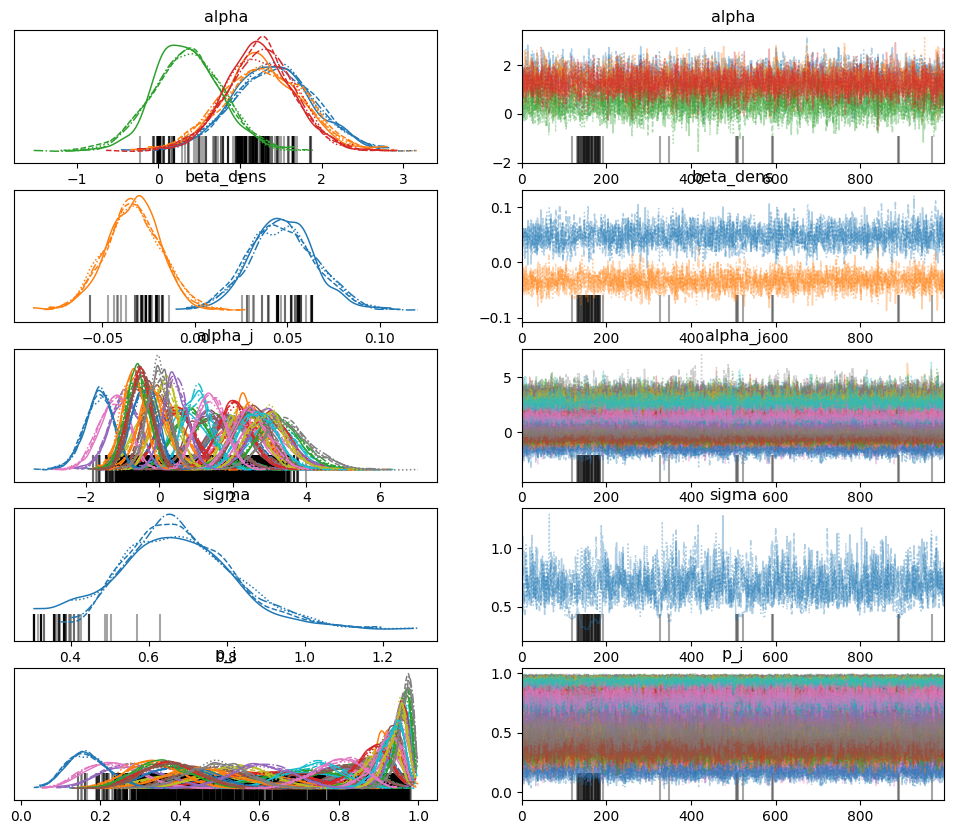

In [80]:
with model:
    # pm.plot_trace(trace, var_names=["alpha_predsize"], compact=False)
    pm.plot_trace(trace)
    plt.show()


In [81]:
with model:
    posteriors = pm.sample_posterior_predictive(
        trace, var_names=["alpha", "beta_dens"], random_seed=43, samples=1000
    )

In [82]:
posteriors["alpha"].mean(axis=0)

array([1.3890022 , 1.26089753, 0.35205633, 1.23986756])

In [83]:
posteriors["beta_dens"].mean(axis=0)

array([ 0.04748308, -0.03339894])